<a href="https://colab.research.google.com/github/prashanth-ds-ml/Projects/blob/main/Object_Localization_with_TensorFlow_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization with TensorFlow

Created for the Coursera Guided Project: [Object Localization with TensorFlow](https://www.coursera.org/projects/object-localization-tensorflow)

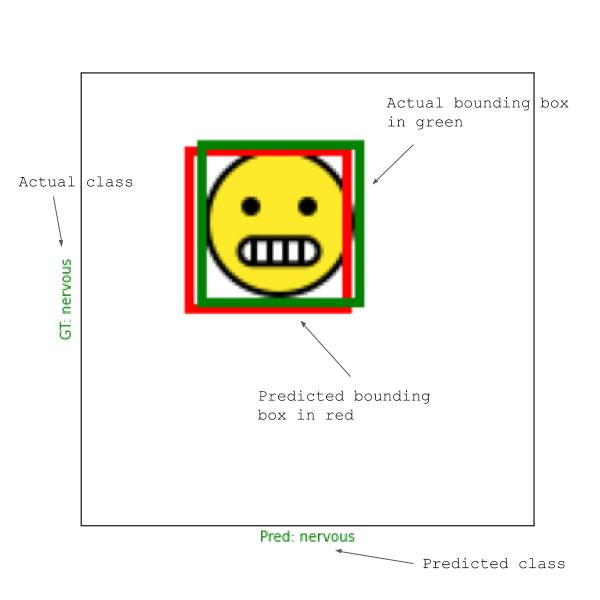

All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

## Task 2: Download and Visualize Data

In [1]:
import requests
import zipfile
import io
import os

In [2]:
url = 'https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip'

In [3]:
response = requests.get(url)

In [4]:
if response.status_code == 200:
    zip_file = io.BytesIO(response.content)
    with zipfile.ZipFile(zip_file,'r') as archive:
        archive.extractall('emojis')
    print('OpenMoji dataset downloaded and extracted')
else:
    print(f'Failed to download OpenMoji dataset. Status code: {response.status_code}')

OpenMoji dataset downloaded and extracted


In [5]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('TensorFlow version', tf.__version__)

TensorFlow version 2.11.0


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

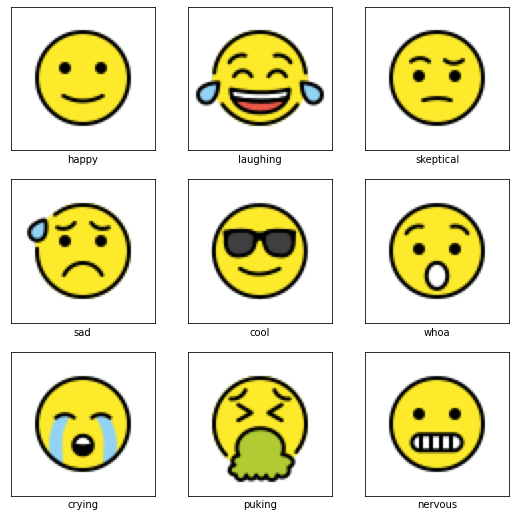

In [7]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Task 3: Create Examples

In [8]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [9]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5F08F66700>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5E5B501220>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5ED9DC8370>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5E51345C40>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5EE91F8340>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5E51345CD0>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5E5B5010A0>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F5E5B501040>},
 8: {'name': 'nervous',
  'file': '

In [10]:
def creating_examples():
    class_id = np.random.randint(0,9)
    image = np.ones((144,144,3)) * 255
    row = np.random.randint(0,72)
    col = np.random.randint(0,72)
    image[row:row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'),class_id,(row + 10) / 144 ,(col + 10) / 144

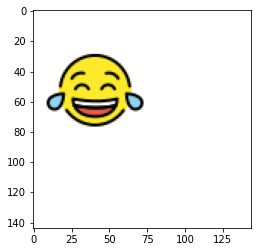

In [11]:
image,class_id,row,col = creating_examples()
plt.imshow(image)
plt.show()

## Task 4: Plot Bounding Boxes

In [12]:
def plot_bounding_boxes(image, coords, pred_coords = [],norm = False):
    if norm:
        image *= 255
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    row,col = coords
    row *= 144
    col *= 144
    draw.rectangle((col,row,col + 52,row + 52),outline = 'green',width = 3)
    
    if len(pred_coords) == 2:
        row,col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col,row,col + 52,row + 52),outline = 'red',width = 3)
        
    return image
        

## Task 5: Data Generator

In [13]:
def data_generator(batch_size = 16):
    while True:
        X_batch = np.zeros((batch_size,144,144,3))
        y_batch = np.zeros((batch_size,9))
        bbox_batch = np.zeros((batch_size,2))
        
        for i in range(0,batch_size):
            image,class_id,row,col = creating_examples()
            X_batch[i] = image / 255
            y_batch[i,class_id] = 1.0
            bbox_batch[i] = np.array([row,col])
        yield{'image':X_batch},{'class_out':y_batch,'box_out':bbox_batch}

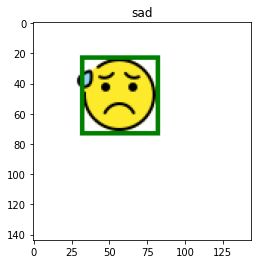

In [14]:
example,label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_boxes(image,coords,norm = True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Task 6: Model

In [15]:
input_shape = Input(shape=(144,144,3),name = 'image')

x = input_shape

for i in range(0,5):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters,3,activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256,activation = 'relu')(x)

class_out = Dense(9,activation = 'softmax',name = 'class_out')(x)
box_out = Dense(2,name = 'box_out')(x)

model = tf.keras.models.Model(input_shape,[class_out,box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 142, 142, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 142, 142, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Task 7: Custom Metric: IoU

In [16]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU,self).__init__(**kwargs)
        
        self.iou = self.add_weight(name = 'iou',initializer = 'zeros')
        self.total_iou = self.add_weight(name = 'total_iou',initializer = 'zeros')
        self.num_ex = self.add_weight(name = 'num_ex',initializer = 'zeros')
        
    def update_state(self,y_true,y_pred,sample_weight = None):
        def get_box(y):
            rows,cols = y_true[:,0],y_true[:,1]
            rows,cols = rows * 144,cols * 144
            y1,y2 = rows,rows + 52
            x1,x2 = cols,cols + 52
            return x1,x2,y1,y2
        def get_area(x1,y1,x2,y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 -y1)
        
        gt_x1,gt_y1,gt_x2,gt_y2 = get_box(y_true)
        p_x1,p_y1,p_x2,p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1,p_x1)
        i_y1 = tf.maximum(gt_y1,p_y1)
        i_x2 = tf.maximum(gt_x2,p_x2)
        i_y2 = tf.maximum(gt_y2,p_y2)
        
        i_area = get_area(i_x1,i_y1,i_x2,i_y2)
        u_area = get_area(gt_x1,gt_y1,gt_x2,gt_y2) + get_area(p_x1,p_y1,p_x2,p_y2) - i_area
        
        iou = tf.math.divide(i_area,u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name = 'iou',initializer = 'zeros')
        self.total_iou = self.add_weight(name = 'total_iou',initializer = 'zeros')
        self.num_ex = self.add_weight(name = 'num_ex',initializer = 'zeros')
        

## Task 8: Compile the Model

In [17]:
model.compile(loss = {'class_out': 'categorical_crossentropy',
                      'box_out': 'mse'},
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = {'class_out':'accuracy',
                         'box_out':IoU(name = 'iou')})

## Task 9: Custom Callback: Model Testing

In [18]:
def test_model(model,test_datagen):
    example,label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y,pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    coords = box[0]
    class_pred = np.argmax(pred_y[0])
    image = x[0]
    
    gt = emojis[np.argmax(y[0])]['name']
    class_pred_name = emojis[class_pred]['name']
    
    image = plot_bounding_boxes(image,coords,pred_coords,norm = True)
    color = 'green' if gt == class_pred_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'pred:{class_pred_name}',color = color)
    plt.ylabel(f'GT:{gt}', color = color)
    plt.xticks([])
    plt.yticks([])    

In [19]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize = (16,4))
    
    for i in range(0,6):
        plt.subplot(1,6, i+1)
        test_model(model,test_datagen)
    plt.show()
        

1/1 [==============================] - 0s 32ms/step


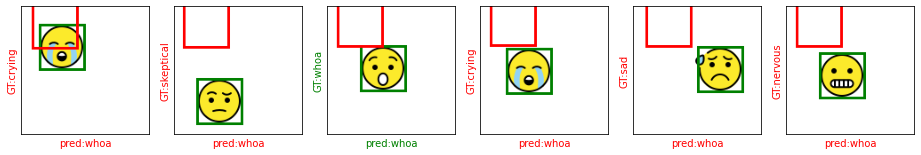

In [20]:
test(model)

In [21]:
class showtestimages(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = None):
    test(self.model)

## Task 10: Model Training

Epoch 1/50


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1/1 [==============================] - 0s 18ms/step


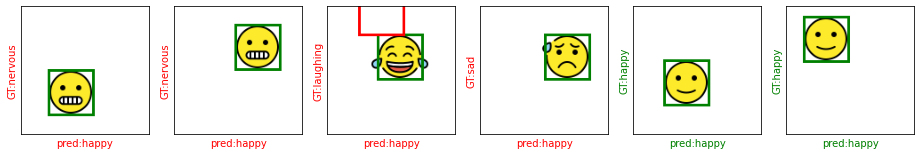

500/500 [==============================] - 19s 20ms/step - loss: 0.8482 - class_out_loss: 0.6232 - box_out_loss: 0.2251 - class_out_accuracy: 0.7965 - box_out_iou: nan - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 20ms/step


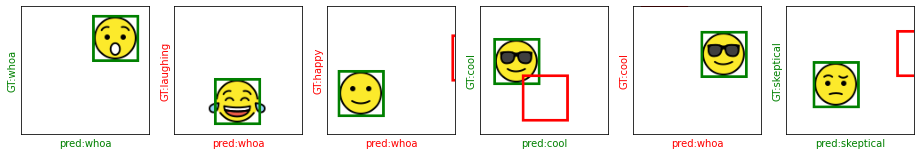

500/500 [==============================] - 9s 18ms/step - loss: 0.0336 - class_out_loss: 0.0099 - box_out_loss: 0.0237 - class_out_accuracy: 0.9992 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 22ms/step


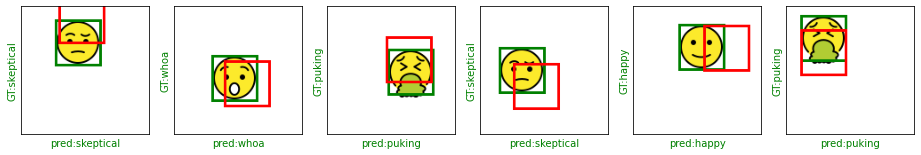

500/500 [==============================] - 10s 21ms/step - loss: 0.0148 - class_out_loss: 0.0032 - box_out_loss: 0.0116 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 20ms/step


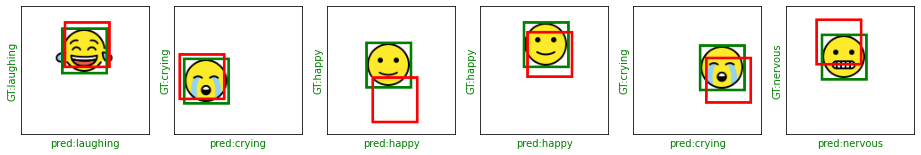

500/500 [==============================] - 10s 19ms/step - loss: 0.0072 - class_out_loss: 0.0014 - box_out_loss: 0.0058 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 23ms/step


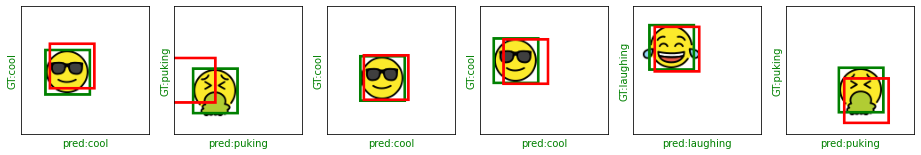

500/500 [==============================] - 10s 21ms/step - loss: 0.0034 - class_out_loss: 9.4569e-04 - box_out_loss: 0.0024 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 2.0000e-04


In [22]:
def lr_schedule(epoch,lr):
  if (epoch + 1)%5 == 0:
    lr *= 0.2
  return max(lr,3e-7)

_ = model.fit(
    data_generator(),
    epochs = 50,
    steps_per_epoch=500,
    callbacks=[
        showtestimages(),
        tf.keras.callbacks.EarlyStopping(monitor = 'box_out_iou',patience = 3,mode ='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)